**Table of contents** 
- Get the Data and Preparing Features 
    - Classes Distribution  
    - High Null Values Columns   
    - Individual Columns 
    - Get Dummies (One-Hot-Encoding) 
    - Optimize df and drop negative perms from permutation rank features 
- Split and Preprocessing for Model  
    - Ordinal Encoder Strings   
    - Undersampling majority classes    
    - Missing Values    
    - Normalization 
- Models   
    - LightGBM    
    - Catboost 
    - XGboost   
    - Ranking Features (feature_importances and Permutation)   
    - Fine Tunning Model (optuna Lightgbm)
    - Others Metrics (Gradient Boosting, Extra-Tree)   
    - Undersampling majority classes variations   
- Sample Submission and Stacking Ensemble   
    - Stack Ensemble Model  
    - Submission 

Setup and Imports

In [1]:
import pandas as pd
import numpy as np
from dtype_diet import report_on_dataframe, optimize_dtypes
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score

# Get the Data and Preparing Features

Classes Distribution | Columns with high null values | Individual Columns | Get Dummies | Optimized DF and drop negative perms

In [2]:
df_ini = pd.read_csv('train.csv')

### Classes Distribution

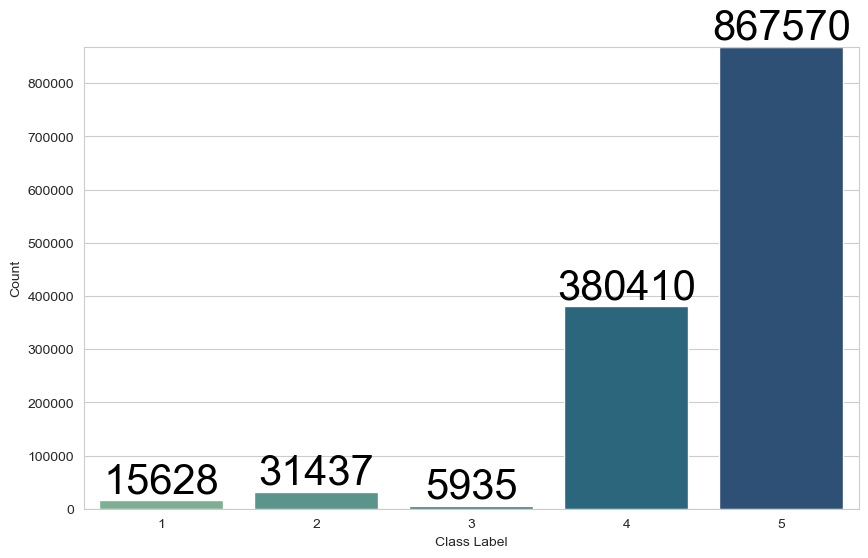

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
plt.figure(figsize=(10,6))

# Set the y-axis limit
plt.ylim(0, max(df_ini["CLASSI_FIN"].value_counts())+1000)

# Plot the countplot
sns.countplot(x="CLASSI_FIN", data=df_ini, palette="crest")

# Add count labels above the bars
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.0f}', 
                       (p.get_x()+p.get_width()/2, p.get_height()+100),
                       ha='center', va='bottom', color='black',fontsize=30)

plt.xlabel("Class Label")
plt.ylabel("Count")
plt.show()

### High Null Values Columns

In [4]:
# #Low values Columns
low_cols_drop = ['DELTA_UTI','HISTO_VGM']
low_cols_fill = ['SURTO_SG','MAE_VAC','M_AMAMENTA']
low_cols_1or0 = ['OUT_ANIM','OBES_IMC','PAC_COCBO','PAC_DSCBO','TOMO_OUT','RAIOX_OUT']
med_cols_str = ["OUTRO_DES",'MORB_DESC'] #Encoda ou não
low_cols = low_cols_drop + low_cols_fill + low_cols_1or0 + med_cols_str
# df_ini= df_ini.drop(low_cols_drop,axis=1)
df_ini[low_cols_fill] = df_ini[low_cols_fill].fillna(-1) 
for col in low_cols_1or0:
    df_ini[col] = df_ini[col].apply(lambda x: 1 if pd.notnull(x) else -1)

low_cols_drop = low_cols_drop + med_cols_str
df_ini= df_ini.drop(low_cols_drop,axis=1)

### Individual Columns

In [5]:
df_ini["COD_IDADE"] = pd.to_numeric(df_ini["COD_IDADE"], errors="coerce").fillna(-1)
df_ini["COD_IDADE"] = df_ini["COD_IDADE"].astype(float)
df_ini['CS_SEXO']= df_ini['CS_SEXO'].map({"M": 0, "F": 1,'I':-1})
df_ini["TP_ANTIVIR"] = df_ini["TP_ANTIVIR"].fillna(-1) 
str_encode = ['ID_REGIONA','ID_MUNICIP','OUT_AMOST']
num_encode = ['CO_REGIONA','CO_MUN_NOT','SEM_NOT','SEM_PRI']
df_ini[num_encode] = df_ini[num_encode].fillna(-1)

### Get Dummies (One-Hot-Encoding)

In [6]:
categoric_num_cols = ['DOSE_REF', 'DOSE_2_COV', 'DOSE_1_COV', 'FATOR_RISC', 'TP_IDADE', 'HOSPITAL', 'AMOSTRA',
  'UTI', 'SUPORT_VEN', 'TOSSE', 'DISPNEIA', 'NOSOCOMIAL', 'SATURACAO', 'ANTIVIRAL', 'FEBRE', 'FNT_IN_COV',
  'VACINA_COV', 'DESC_RESP', 'VACINA', 'FADIGA', 'OUTRO_SIN', 'GARGANTA', 'DIARREIA', 'VOMITO', 'PERD_OLFT', 'PERD_PALA', 'DOR_ABD', 
    'CARDIOPATI', 'OUT_MORBI', 'DIABETES', 'OBESIDADE', 'NEUROLOGIC', 'PNEUMOPATI', 'ASMA', 'RENAL', 'IMUNODEPRE', 'HEMATOLOGI',
   'PUERPERA', 'SIND_DOWN', 'HEPATICA',"SG_UF","SG_UF_NOT","CS_GESTANT","CS_RACA","CS_ESCOL_N","TOMO_RES","RAIOX_RES","TP_AMOSTRA","AVE_SUINO","CS_ZONA"]
df_encoded = df_ini.drop(categoric_num_cols, axis=1).copy()
df_ini[categoric_num_cols] = df_ini[categoric_num_cols].fillna(9)
for col in categoric_num_cols:
    df_encoded = pd.concat([df_encoded, pd.get_dummies(df_ini[col], prefix=col, prefix_sep="_")], axis=1)
df_ini = df_encoded

### Optimize df and drop negative perms from permutation rank features

In [7]:
from dtype_diet import report_on_dataframe, optimize_dtypes
optimized_df = report_on_dataframe(df_ini,unit = "MB")
df_ini = optimize_dtypes(df_ini,optimized_df)
# Negative permutations after Ranking Features
negative_perms= ['ASMA_9.0', 'AVE_SUINO_1.0', 'AVE_SUINO_3.0', 'CARDIOPATI_9.0',       'CS_ESCOL_N_0.0', 'CS_ESCOL_N_4.0', 'CS_GESTANT_0', 'CS_GESTANT_4',
       'CS_GESTANT_9', 'CS_RACA_2', 'CS_RACA_3', 'CS_ZONA_3.0',       'DESC_RESP_2.0', 'DIARREIA_9.0', 'DOR_ABD_1.0', 'DOSE_2_COV_1',
       'FEBRE_2.0', 'FEBRE_9.0', 'GARGANTA_9.0', 'HEMATOLOGI_9.0',       'HEPATICA_1.0', 'HOSPITAL_2.0', 'NEUROLOGIC_9.0', 'NOSOCOMIAL_2.0',
       'OBES_IMC', 'OUTRO_SIN_2.0', 'OUT_ANIM', 'OUT_MORBI_2.0',       'PERD_OLFT_2.0', 'PNEUMOPATI_9.0', 'PUERPERA_1.0', 'PUERPERA_2.0',
       'PUERPERA_9.0', 'RAIOX_OUT', 'RAIOX_RES_1.0', 'RAIOX_RES_2.0',       'RENAL_9.0', 'SATURACAO_9.0', 'SG_UF_9', 'SG_UF_AC', 'SG_UF_AL',
       'SG_UF_AP', 'SG_UF_DF', 'SG_UF_MS', 'SG_UF_NOT_AM', 'SG_UF_NOT_AP',       'SG_UF_NOT_MS', 'SG_UF_NOT_PE', 'SG_UF_NOT_PI', 'SG_UF_NOT_RN',
       'SG_UF_NOT_RO', 'SG_UF_NOT_RR', 'SG_UF_NOT_TO', 'SG_UF_RO', 'SG_UF_RR',       'SG_UF_SE', 'SG_UF_SP', 'SIND_DOWN_1.0', 'TOSSE_9.0', 'TP_AMOSTRA_3.0',
       'TP_AMOSTRA_4.0', 'TP_AMOSTRA_5.0', 'TP_IDADE_1', 'VOMITO_1.0',       'VOMITO_2.0', 'VOMITO_9.0']
df_ini= df_ini.drop(negative_perms,axis=1)

# Split and Preprocessing for Model

Split | Ordinal Encode Strings | Undersampling Majority Classes | Missing Values | Normalization

In [8]:
df = df_ini.copy()
X_train_ini, X_test_ini, y_train_ini, y_test_ini = train_test_split(df.drop(['CLASSI_FIN','ID'], axis=1), df['CLASSI_FIN'], test_size=0.2, random_state=45)

In [9]:
X_train,X_test,y_train,y_test = X_train_ini, X_test_ini, y_train_ini, y_test_ini

### Ordinal Encoder Strings

In [10]:
from sklearn.preprocessing import OrdinalEncoder
ord = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = -1)
X_train[str_encode] = ord.fit_transform(X_train[str_encode])
X_test[str_encode]= ord.transform(X_test[str_encode])

### Undersampling majority classes

In [11]:
# set random seed
np.random.seed(62)

# identify the indices of the rows where CLASSI_FIN is 4 or 5
indices_4 = y_train.index[y_train == 4].tolist()
indices_5 = y_train.index[y_train == 5].tolist()

# calculate the number of samples to reduce
n_samples_to_reduce_4 = int(0.7 * len(indices_4))
n_samples_to_reduce_5 = int(0.8 * len(indices_5))

# randomly select indices to drop
indices_to_drop_4 = np.random.choice(indices_4, size=n_samples_to_reduce_4, replace=False)
indices_to_drop_5 = np.random.choice(indices_5, size=n_samples_to_reduce_5, replace=False)

# drop the selected rows from the DataFrame
X_train = X_train.drop(indices_to_drop_4)
y_train = y_train.drop(indices_to_drop_4)
X_train = X_train.drop(indices_to_drop_5)
y_train = y_train.drop(indices_to_drop_5)

### Missing Values

In [12]:
X_train = X_train.fillna(9)
X_train = X_train.replace(9,-1)
X_test = X_test.fillna(9)
X_test = X_test.replace(9,-1)

### Normalization

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# Transform the training and test data using the fitted scaler
X_train = scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

# Models

LightGBM | Catboost | XGBoost | Ranking Features | Fine-Tuning LightGBM with Optuna | Gradient Boosting | Extra-Tree | Undersampling Majority Classes Variations

### LightGBM

In [14]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score

# Define the LightGBM classifier
clf = lgb.LGBMClassifier(learning_rate=0.3960812137215295, num_leaves=30,max_depth= 9,min_child_samples=42,subsample = 0.7680910752059882,
                         colsample_bytree = 0.6923541712639206, reg_lambda= 25.7697984404729, reg_alpha= 0.48577032192937336,random_state=0,
                         objective='multiclass', num_class=np.unique(y_train), metric='multi_logloss',n_jobs=-1,n_estimators = 196)
                         #,scale_pos_weight=scale_pos_weight)

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the performance of the classifier
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='macro')
rec = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
print(f'Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-score: {f1:.4f}')

Accuracy: 0.7923, Precision: 0.5482, Recall: 0.6283, F1-score: 0.5792


In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X_train, y_train,n_jobs=-1, cv=5,scoring='f1_macro')
average_score = np.mean(scores)
# Print the average cross-validation score
print(f"Mean F1 score: {average_score} | Std Dev F1 score: {scores.std()}")

Mean F1 score: 0.6661030786795589 | Std Dev F1 score: 0.003002254846360272


### Catboost

In [97]:
import catboost as cb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

# Define the CatBoost classifier with class weighting
clf = cb.CatBoostClassifier(learning_rate=0.49075540364386505, depth=6, l2_leaf_reg=19.96595712418598, 
                            random_state=0, loss_function='MultiClass', eval_metric='MultiClass')
                            
# Fit the classifier to the training data
y_train = y_train.astype(int)
clf.fit(X_train, y_train, verbose=False)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the performance of the classifier
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='macro')
rec = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
print(f'Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-score: {f1:.4f}')

Accuracy: 0.7913, Precision: 0.5491, Recall: 0.6272, F1-score: 0.5793


### XGboost

In [187]:
class_mapping = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
y_train = np.array([class_mapping[label] for label in y_train])
y_test = np.array([class_mapping[label] for label in y_test])

import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the XGBoost classifier
clf = xgb.XGBClassifier(learning_rate=0.1, max_depth=9, n_estimators=100,reg_alpha = 0.1, eval_metric='mlogloss', objective='multi:softprob', random_state=0)

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the performance of the classifier
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='macro')
rec = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
print(f'Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-score: {f1:.4f}')

Accuracy: 0.7725, Precision: 0.5440, Recall: 0.6121, F1-score: 0.5680


### Ranking Features (feature_importances and Permutation)

In [ ]:
from sklearn.metrics import f1_score
X_test_df=pd.DataFrame(X_test,columns=X_test_ini.columns)
res = dict()
for col in X_train_ini.columns:
    X_test_ = X_test_df.copy()
    X_test_[col] = np.random.permutation(X_test_[col])   
    p = clf.predict(X_test_)
    f1 = f1_score(y_test, p,average='macro')
    res[col] = f1
    print("Feature: {} | f1: {:.4f} | f1 Delta: {:.4f}".format(col, f1,  0.5806 - f1))

In [ ]:
fimp_perm = (0.5806 - pd.Series(res)).sort_values() 
fimp_lgbm = pd.Series(clf.feature_importances_, index=X_train_ini.columns).sort_values(ascending=False)
fimps = pd.DataFrame({"fimp_perm": fimp_perm, "fimp_lgbm": fimp_lgbm})
#fimps.corr()
negative_perms = fimps[fimps['fimp_perm'] < 0].index
fimps.sort_values("fimp_lgbm",ascending =False)
#fimps_rank = fimps.rank(ascending=True).sort_values("fimp_perm")
#fimps_rank.mean(axis=1).sort_values()

### Fine Tunning Model (optuna Lightgbm)

In [ ]:
import lightgbm as lgb
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import optuna

def objective(trial):
    # Define the LightGBM classifier
    params = {
        "objective": "multiclass",
        "metric": "multi_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "max_depth":trial.suggest_int("max_depth", 1,10),
        "num_leaves": trial.suggest_int("num_leaves", 2, 31),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.01, 0.5),
        "subsample": trial.suggest_uniform("subsample", 0.1, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.1, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.1, 100.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.1, 100.0),
        'n_estimators': trial.suggest_int('n_estimators',1,200),
        "num_class": 5
    }

    clf = lgb.LGBMClassifier(**params)

    # Fit the classifier to the training data
    clf.fit(X_train, y_train)

    # Make predictions on the validation data
    y_pred = clf.predict(X_test)

    # Calculate the F1 score
    score = f1_score(y_test, y_pred, average='macro')

    return score

if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=150)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    print("Best F1-score: {:.3f}".format(trial.value))

### Others Metrics (Gradient Boosting, Extra-Tree)

In [818]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Define the Gradient Boosting Classifier
clf = GradientBoostingClassifier(n_estimators=71, learning_rate=0.1,
                                 max_depth=9, n_jobs=-1, random_state=0)
# Create an instance of the OneVsRestClassifier class
ovr_clf = OneVsRestClassifier(clf)
# Fit the OvR classifier to the training data
y_train = y_train.astype(int)
ovr_clf.fit(X_train, y_train)
# Make predictions on the test data
y_pred = ovr_clf.predict(X_test)
# Evaluate the performance of the OvR classifier
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='macro')
rec = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
print(f'Accuracy: {acc:.2f}, Precision: {prec:.2f}, Recall: {rec:.2f}, F1-score: {f1:.2f}')

Accuracy: 0.76, Precision: 0.54, Recall: 0.58, F1-score: 0.54


In [146]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the ExtraTrees classifier with class weighting
clf = ExtraTreesClassifier(class_weight='balanced',max_depth= 7)

# Fit the classifier to the training data
y_train = y_train.astype(int)
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the performance of the classifier
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='macro')
rec = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
print(f'Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-score: {f1:.4f}')

Accuracy: 0.5607, Precision: 0.3255, Recall: 0.5499, F1-score: 0.2711


### Undersampling majority classes variations

In [ ]:
indices_4 = y_train.index[y_train == 4].tolist()
indices_5 = y_train.index[y_train == 5].tolist()
clf = lgb.LGBMClassifier(learning_rate=0.49075540364386505, num_leaves=29,max_depth= 6,min_child_samples=28,feature_fraction= 0.8184448875126882,
                         bagging_fraction= 0.8579122108890788, reg_lambda= 19.96595712418598, reg_alpha= 1.1657939377009074,random_state=0,
                         objective='multiclass', num_class=5, metric='multi_logloss',verbose=-1) 
np.random.seed(42)
for i in np.arange(0.6,0.96, 0.05):
    for j in np.arange(0.6,0.96,0.05):
        # calculate the number of samples to reduce
        X_train,X_test,y_train,y_test = X_train_ini, X_test_ini, y_train_ini, y_test_ini
        n_samples_to_reduce_4 = int(i * len(indices_4))
        n_samples_to_reduce_5 = int(j * len(indices_5))
        # randomly select indices to drop
        indices_to_drop_4 = np.random.choice(indices_4, size=n_samples_to_reduce_4, replace=False)
        indices_to_drop_5 = np.random.choice(indices_5, size=n_samples_to_reduce_5, replace=False)
        X_train = X_train.drop(indices_to_drop_4)
        y_train = y_train.drop(indices_to_drop_4)
        X_train = X_train.drop(indices_to_drop_5)
        y_train = y_train.drop(indices_to_drop_5)
        # Apply notnull transformation to training set
        for col in ['PAC_DSCBO', 'PAC_COCBO', 'OUT_AMOST', 'OBES_IMC']:
            X_train[col] = X_train[col].apply(lambda x: 1 if pd.notnull(x) else 0)
            X_test[col] = X_test[col].apply(lambda x: 1 if pd.notnull(x) else 0)
        X_train = X_train.fillna(9)
        X_test = X_test.fillna(9)
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test= scaler.transform(X_test)
        y_train = y_train.astype(int)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='macro')
        rec = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')
        print(f'class 4(i): {i} class 5(j): {j}\nAccuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-score: {f1:.4f}')
        scores = cross_val_score(clf, X_train, y_train,n_jobs=-1, cv=3,scoring='f1_macro')
        average_score = np.mean(scores)
        print(f"Mean F1 score: {average_score} Std Dev F1 score: {scores.std()}")        

# Sample Submission and Stacking Ensemble

In [ ]:
df_test_ini = pd.read_csv('test.csv')

In [189]:
df_test = df_test_ini.copy()
# #Low values Columns
low_cols_drop = ['DELTA_UTI','HISTO_VGM']
low_cols_fill = ['SURTO_SG','MAE_VAC','M_AMAMENTA']
low_cols_1or0 = ['OUT_ANIM','OBES_IMC','PAC_COCBO','PAC_DSCBO','TOMO_OUT','RAIOX_OUT']
med_cols_str = ["OUTRO_DES",'MORB_DESC'] #Encoda ou não
# df_test= df_test.drop(low_cols_drop,axis=1)
df_test[low_cols_fill] = df_test[low_cols_fill].fillna(9) 
for col in low_cols_1or0:
    df_test[col] = df_test[col].apply(lambda x: 1 if pd.notnull(x) else 0)

low_cols_drop = low_cols_drop + med_cols_str
df_test= df_test.drop(low_cols_drop,axis=1)

# Individual Columns
df_test["COD_IDADE"] = pd.to_numeric(df_test["COD_IDADE"], errors="coerce").fillna(0)
df_test["COD_IDADE"] = df_test["COD_IDADE"].astype(float)
df_test['CS_SEXO']= df_test['CS_SEXO'].map({"M": 0, "F": 1,'I':9})
df_test["TP_ANTIVIR"] = df_test["TP_ANTIVIR"].fillna(0) # is a low cow fill too
str_encode = ['ID_REGIONA','ID_MUNICIP','OUT_AMOST']
num_encode = ['CO_REGIONA','CO_MUN_NOT','SEM_NOT','SEM_PRI']
df_test[num_encode] = df_test[num_encode].fillna(-1)

#Get Dummies
categoric_num_cols = ['DOSE_REF', 'DOSE_2_COV', 'DOSE_1_COV', 'FATOR_RISC', 'TP_IDADE', 'HOSPITAL', 'AMOSTRA',
  'UTI', 'SUPORT_VEN', 'TOSSE', 'DISPNEIA', 'NOSOCOMIAL', 'SATURACAO', 'ANTIVIRAL', 'FEBRE', 'FNT_IN_COV',
  'VACINA_COV', 'DESC_RESP', 'VACINA', 'FADIGA', 'OUTRO_SIN', 'GARGANTA', 'DIARREIA', 'VOMITO', 'PERD_OLFT', 'PERD_PALA', 'DOR_ABD', 
    'CARDIOPATI', 'OUT_MORBI', 'DIABETES', 'OBESIDADE', 'NEUROLOGIC', 'PNEUMOPATI', 'ASMA', 'RENAL', 'IMUNODEPRE', 'HEMATOLOGI',
   'PUERPERA', 'SIND_DOWN', 'HEPATICA',"SG_UF","SG_UF_NOT","CS_GESTANT","CS_RACA","CS_ESCOL_N","TOMO_RES","RAIOX_RES","TP_AMOSTRA","AVE_SUINO","CS_ZONA"]
df_encoded = df_test.drop(categoric_num_cols, axis=1).copy()
df_test[categoric_num_cols] = df_test[categoric_num_cols].fillna(9)
for col in categoric_num_cols:
    df_encoded = pd.concat([df_encoded, pd.get_dummies(df_test[col], prefix=col, prefix_sep="_")], axis=1)
df_test = df_encoded

from dtype_diet import report_on_dataframe, optimize_dtypes
optimized_df = report_on_dataframe(df_test,unit = "MB")
df_test = optimize_dtypes(df_test,optimized_df)
df_test= df_test.drop(negative_perms,axis=1)

df_test[str_encode]= ord.transform(df_test[str_encode])  

In [190]:
df_test = df_test.fillna(9)
test_id = df_test["ID"]
df_test= df_test.drop("ID",axis=1)
df_test = scaler.transform(df_test)

### Stack Ensemble Model

In [424]:
y_pred1_rf1 = pd.read_csv('ensemble/predicted_data_tuned.csv')['CLASSI_FIN'].to_numpy()
y_pred1_rf2 = pd.read_csv('ensemble/marcha_favela_vai_vencer(1).csv')['CLASSI_FIN'].to_numpy()
y_pred1_rf3 = pd.read_csv('ensemble/predicted_eh_marcha(2)(1).csv')['CLASSI_FIN'].to_numpy()
y_pred1_rf4 = pd.read_csv('ensemble/predicted_data_marcha_frente.csv')['CLASSI_FIN'].to_numpy()
y_pred1_rf5 = pd.read_csv('ensemble/predicted_data_quinta_marcha(1).csv')['CLASSI_FIN'].to_numpy()
y_pred1_rf24 = pd.read_csv('predicted_data_marcha.csv')['CLASSI_FIN'].to_numpy()
y_pred1_rf6 = pd.read_csv('ensemble/teste_submissao_features.csv')['CLASSI_FIN'].to_numpy()
y_pred1_rf7 = pd.read_csv('ensemble/ensible_.csv')['CLASSI_FIN'].to_numpy()
y_pred1_rf8 = pd.read_csv('ensemble/ensemble_catboost.csv')['CLASSI_FIN'].to_numpy()
y_pred1_rf9 = pd.read_csv('ensemble/mais_1.csv')['CLASSI_FIN'].to_numpy()
y_pred1_rf10 = pd.read_csv('ensemble/ensemble2_.csv')['CLASSI_FIN'].to_numpy() 
y_pred1_rf11 = pd.read_csv('ensemble/1.csv')['CLASSI_FIN'].to_numpy()
y_pred1_rf12 = pd.read_csv('ensemble/2.csv')['CLASSI_FIN'].to_numpy()
y_pred1_rf13 = pd.read_csv('ensemble/3.csv')['CLASSI_FIN'].to_numpy()
y_pred1_rf14 = pd.read_csv('ensemble/ensemblelgbm.csv')['CLASSI_FIN'].to_numpy()
y_pred1_rf15 = pd.read_csv('ensemble/ensemble3_.csv')['CLASSI_FIN'].to_numpy()
y_pred1_rf16 = pd.read_csv('ensemble/ensemble4_.csv')['CLASSI_FIN'].to_numpy()
y_pred1_rf17 = pd.read_csv('ensemblecatboost.csv')['CLASSI_FIN'].to_numpy()
y_pred1_rf18 = pd.read_csv('ensemblexgboost.csv')['CLASSI_FIN'].to_numpy()
y_pred1_rf19 = pd.read_csv('4.csv')['CLASSI_FIN'].to_numpy()
y_pred1_rf20= pd.read_csv('5.csv')['CLASSI_FIN'].to_numpy()
y_pred1_rf21= pd.read_csv('newensemble2.csv')['CLASSI_FIN'].to_numpy() #referencia
y_pred1_rf22= pd.read_csv('newensemble_conserva.csv')['CLASSI_FIN'].to_numpy() 
y_pred1_rf23= pd.read_csv('predicted_data_seraqmarcha.csv')['CLASSI_FIN'].to_numpy()

In [425]:
from scipy import stats
contador=0
for i in range(0,len(y_pred1_rf3)):
    aux = np.array(list([y_pred1_rf1[i],y_pred1_rf2[i],y_pred1_rf3[i],y_pred1_rf4[i],y_pred1_rf5[i],y_pred1_rf6[i],y_pred1_rf7[i],
    y_pred1_rf8[i],y_pred1_rf9[i],y_pred1_rf10[i],y_pred1_rf11[i],y_pred1_rf12[i],y_pred1_rf13[i],y_pred1_rf14[i],y_pred1_rf15[i],
    y_pred1_rf16[i],y_pred1_rf17[i],y_pred1_rf18[i],y_pred1_rf19[i],y_pred1_rf20[i],y_pred1_rf21[i],y_pred1_rf22[i],y_pred1_rf23[i],
     y_pred1_rf24[i]]))    
    value,check = stats.mode(aux)
    if(check[0] == 1):
        continue
    else:
        if(y_pred1_rf21[i] != value[0]):
            contador += 1
        y_pred1_rf21[i] = value[0]

In [191]:
pred_test = clf.predict(df_test)
#pred_test = pred_test.reshape(-1)

### Submission

In [332]:
submission_file = pd.read_csv('sample_submission.csv')
submission_file['CLASSI_FIN'] = y_pred1_rf21
submission_file.to_csv('newensemble_final.csv',index=False)